# Frequency correlation plots for simulated populations

Another attempt at calculating clade frequencies from tip-to-clade mappings without using a full tree.

In [1]:
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def matthews_correlation_coefficient(tp, tn, fp, fn):
    """Return Matthews correlation coefficient for values from a confusion matrix.
    Implementation is based on the definition from wikipedia:

    https://en.wikipedia.org/wiki/Matthews_correlation_coefficient
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    if denominator == 0:
            denominator = 1

    return float(numerator) / denominator

def get_matthews_correlation_coefficient_for_data_frame(freq_df, return_confusion_matrix=False):
        """Calculate Matthew's correlation coefficient from a given pandas data frame
        with columns for initial, observed, and predicted frequencies.
        """
        observed_growth = (freq_df["observed_frequency"] > freq_df["initial_frequency"])
        predicted_growth = (freq_df["estimated_frequency"] > freq_df["initial_frequency"])
        true_positives = ((observed_growth) & (predicted_growth)).sum()
        false_positives= ((~observed_growth) & (predicted_growth)).sum()

        observed_decline = (freq_df["observed_frequency"] <= freq_df["initial_frequency"])
        predicted_decline = (freq_df["estimated_frequency"] <= freq_df["initial_frequency"])
        true_negatives = ((observed_decline) & (predicted_decline)).sum()
        false_negatives = ((~observed_decline) & (predicted_decline)).sum()

        mcc = matthews_correlation_coefficient(
            true_positives,
            true_negatives,
            false_positives,
            false_negatives
        )

        if return_confusion_matrix:
            confusion_matrix = {
                "tp": true_positives,
                "tn": true_negatives,
                "fp": false_positives,
                "fn": false_negatives
            }
            
            return mcc, confusion_matrix
        else:
            return mcc

## Load data

In [6]:
data_root = "../results/builds/simulated/simulated_sample_3/"

In [7]:
tips = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency"]
)

In [8]:
first_validation_timepoint = "2023-10-01"

In [9]:
tips = tips.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [10]:
tips.shape

(22050, 3)

In [11]:
tips["future_timepoint"] = tips["timepoint"] + pd.DateOffset(months=12)

In [12]:
tips.set_index(["timepoint", "future_timepoint", "strain"], inplace=True)

In [13]:
tips.head(1)

,,,frequency
timepoint,future_timepoint,strain,
2023-10-01,2024-10-01,sample_4636_1,0.000013


In [14]:
tips_to_clades = pd.read_csv("%s/tips_to_clades.tsv" % data_root, sep="\t", parse_dates=["timepoint"])

In [15]:
tips_to_clades = tips_to_clades.query("timepoint >= '%s'" % first_validation_timepoint).copy()

In [16]:
tips_to_clades = tips_to_clades.rename(columns={"tip": "strain"})

In [17]:
tips_to_clades.set_index(["timepoint", "strain"], inplace=True)

In [18]:
tips_to_clades.head()

clade_membership  depth
timepoint  strain                                
2023-10-01 sample_3560_60          4d834db      0
           sample_3560_60          80a6fb5      2
           sample_3552_23          14321ad      0
           sample_3552_23          4d834db      2
           sample_3552_23          80a6fb5      3

In [19]:
tips_to_clades.shape

(3403957, 2)

In [20]:
forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["timepoint", "strain", "projected_frequency"]
)

In [21]:
forecasts.set_index(["timepoint", "strain"], inplace=True)

In [22]:
forecasts.head()

projected_frequency
timepoint  strain                             
2016-10-01 sample_3236_14         1.405414e-15
           sample_3236_17         7.802684e-08
           sample_3236_19         8.397902e-11
           sample_3236_21         1.371248e-08
           sample_3236_22         1.671481e-12

In [23]:
full_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [24]:
full_forecasts = full_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).copy()

## Find clades for tips at future timepoint

Annotate projected frequencies for each tip by timepoint.

In [25]:
tips = tips.join(forecasts, on=["timepoint", "strain"])

In [26]:
tips_with_current_clades = tips.join(
    tips_to_clades,
    on=["timepoint", "strain"]
).reset_index().rename(columns={
    "level_0": "timepoint",
    "level_2": "strain"
})

In [27]:
tips_with_current_clades.shape

(550095, 7)

In [28]:
tips_with_current_clades.head()

,timepoint,future_timepoint,strain,frequency,projected_frequency,clade_membership,depth
0,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,a4680e6,0
1,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,ede1e10,4
2,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,59c5a3e,7
3,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,6beb055,8
4,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,3543a7e,9


In [29]:
current_tips_with_future_clades = tips.join(
    tips_to_clades,
    on=["future_timepoint", "strain"]
).reset_index().rename(columns={
    "level_1": "future_timepoint",
    "level_2": "strain"
})

In [30]:
current_tips_with_future_clades.head()

,timepoint,future_timepoint,strain,frequency,projected_frequency,clade_membership,depth
0,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,a4680e6,0.0
1,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,ede1e10,3.0
2,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,59c5a3e,8.0
3,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,6beb055,9.0
4,2023-10-01,2024-10-01,sample_4636_1,0.000013,0.000047,3543a7e,10.0


In [31]:
current_tips_with_future_clades.shape

(448383, 7)

If we take the closest clade to each tip and sum tip frequencies by timepoint, we should get 100% frequency for each timepoint.

In [32]:
current_tips_with_future_clades.groupby(["timepoint", "future_timepoint", "strain", "frequency"]).first().reset_index().groupby([
    "timepoint"
])["frequency"].sum().values

array([0.999937, 0.999936, 0.999948, 0.999969, 0.999941, 0.999946,
       0.999977, 0.999968, 0.99998 , 0.999943, 0.999949, 0.999987,
       0.999965, 0.999966, 0.999952, 0.999962, 0.999954, 0.999936,
       0.99996 , 0.999971, 0.999982, 0.999963, 0.999966, 0.999955,
       0.999973, 0.999985, 0.999994, 0.999973, 0.999955, 0.999951,
       0.999987, 0.999973, 0.999977, 0.999977, 0.999954])

Get distinct list of clades for tips from the future timepoint (this is different from the list of all possible future clades because it is filtered to just those associated with tips that are alive at the future timepoint).

In [33]:
distinct_clades_for_future_tips = tips_with_current_clades.loc[
    :,
    ["timepoint", "future_timepoint", "clade_membership"]
].drop_duplicates()

In [34]:
distinct_clades_for_future_tips.head()

,timepoint,future_timepoint,clade_membership
0,2023-10-01,2024-10-01,a4680e6
1,2023-10-01,2024-10-01,ede1e10
2,2023-10-01,2024-10-01,59c5a3e
3,2023-10-01,2024-10-01,6beb055
4,2023-10-01,2024-10-01,3543a7e


In [36]:
distinct_clades_for_future_tips.shape

(6817, 3)

Merge current tips with future clades with that distinct list and take the closest clade assignment from the future based on the current tip’s depth.

In [37]:
current_tips_with_assigned_clades = current_tips_with_future_clades.merge(
    distinct_clades_for_future_tips,
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_future"],
    copy=False
).sort_values(["timepoint", "strain", "depth"]).groupby([
    "timepoint",
    "strain"
]).first().reset_index().drop(columns=[
    "depth",
    "timepoint_future",
    "future_timepoint_future"
])

In [38]:
current_tips_with_assigned_clades.head()

,timepoint,strain,future_timepoint,frequency,projected_frequency,clade_membership
0,2023-10-01,sample_4636_1,2024-10-01,0.000013,4.717925e-05,ede1e10
1,2023-10-01,sample_4636_10,2024-10-01,0.000013,1.302234e-06,bece2b8
2,2023-10-01,sample_4636_24,2024-10-01,0.000013,5.524085e-08,ede1e10
3,2023-10-01,sample_4636_27,2024-10-01,0.000013,2.090765e-28,bece2b8
4,2023-10-01,sample_4636_33,2024-10-01,0.000013,1.381129e-06,8197a93


In [39]:
current_tips_with_assigned_clades.shape

(20790, 6)

In [40]:
current_tips_with_assigned_clades[current_tips_with_assigned_clades["strain"] == "sample_5416_3"]

,timepoint,strain,future_timepoint,frequency,projected_frequency,clade_membership


Get distinct list of clades for tips from the current timepoint.

In [41]:
distinct_clades_for_current_tips = current_tips_with_assigned_clades.loc[
    :,
    ["timepoint", "future_timepoint", "clade_membership"]
].drop_duplicates()

In [42]:
distinct_clades_for_current_tips.head()

,timepoint,future_timepoint,clade_membership
0,2023-10-01,2024-10-01,ede1e10
1,2023-10-01,2024-10-01,bece2b8
4,2023-10-01,2024-10-01,8197a93
5,2023-10-01,2024-10-01,59c5a3e
6,2023-10-01,2024-10-01,602ca8b


In [43]:
distinct_clades_for_current_tips.shape

(940, 3)

Merge future tips with current timepoint’s future clades and take the closest clade assignment from the future.

In [45]:
future_tips_with_assigned_clades = tips_with_current_clades.merge(
    distinct_clades_for_current_tips,
    left_on=["timepoint", "clade_membership"],
    right_on=["future_timepoint", "clade_membership"],
    suffixes=["", "_current"],
    copy=False
).sort_values(["timepoint", "strain", "depth"]).groupby([
    "timepoint",
    "strain"
]).first().reset_index().drop(columns=[
    "depth",
    "timepoint_current",
    "future_timepoint_current"
])

In [46]:
future_tips_with_assigned_clades.shape

(20790, 6)

In [47]:
future_tips_with_assigned_clades.head()

,timepoint,strain,future_timepoint,frequency,projected_frequency,clade_membership
0,2024-10-01,sample_4836_18,2025-10-01,0.000013,2.107001e-05,a3c7961
1,2024-10-01,sample_4836_22,2025-10-01,0.000013,5.839055e-05,a3c7961
2,2024-10-01,sample_4836_24,2025-10-01,0.000013,8.370902e-14,a3c7961
3,2024-10-01,sample_4836_25,2025-10-01,0.000013,1.174497e-12,a3c7961
4,2024-10-01,sample_4836_28,2025-10-01,0.000013,5.825623e-12,a3c7961


In [48]:
future_tips_with_assigned_clades.query("strain == 'sample_5416_3'")

,timepoint,strain,future_timepoint,frequency,projected_frequency,clade_membership


In [49]:
total_frequencies_for_current_tips = current_tips_with_assigned_clades.groupby(["timepoint"])["frequency"].sum().values

In [50]:
np.allclose(
    np.ones_like(total_frequencies_for_current_tips),
    total_frequencies_for_current_tips,
    1e-4
)

True

In [51]:
total_frequencies_for_future_tips = future_tips_with_assigned_clades.groupby(["timepoint"])["frequency"].sum().values

In [52]:
np.allclose(
    np.ones_like(total_frequencies_for_future_tips),
    total_frequencies_for_future_tips,
    1e-4
)

True

In [53]:
future_clades_for_current_timepoints = current_tips_with_assigned_clades.groupby([
    "timepoint", "future_timepoint", "clade_membership"
]).aggregate({"frequency": "sum", "projected_frequency": "sum"}).reset_index()

In [54]:
future_clades_for_current_timepoints.head()

,timepoint,future_timepoint,clade_membership,frequency,projected_frequency
0,2023-10-01,2024-10-01,2b50f0a,0.014485,0.002036
1,2023-10-01,2024-10-01,31319fe,0.149195,0.114001
2,2023-10-01,2024-10-01,3483876,0.177599,0.086580
3,2023-10-01,2024-10-01,3543a7e,0.004428,0.000183
4,2023-10-01,2024-10-01,48415d3,0.001629,0.000028


In [55]:
future_clades_for_future_timepoints = future_tips_with_assigned_clades.groupby([
    "timepoint", "future_timepoint", "clade_membership"
])["frequency"].sum().reset_index()

In [56]:
future_clades_for_future_timepoints.head()

,timepoint,future_timepoint,clade_membership,frequency
0,2024-10-01,2025-10-01,a3c7961,0.957629
1,2024-10-01,2025-10-01,c8156cb,0.042319
2,2025-04-01,2026-04-01,0435f1e,0.045555
3,2025-04-01,2026-04-01,14a21e2,0.219689
4,2025-04-01,2026-04-01,1ea6a3e,0.561799


In [57]:
np.allclose(
    np.ones_like(future_clades_for_current_timepoints.groupby("timepoint")["frequency"].sum().values),
    future_clades_for_current_timepoints.groupby("timepoint")["frequency"].sum().values,
    1e-4
)

True

Next, find future tips that belong to the same clades as the current tips or which have descended from these clades. Instead of taking every clade assigned to each tip, we want to pick the closest clade to each tip.

In [58]:
merged_clades = future_clades_for_current_timepoints.merge(
    future_clades_for_future_timepoints,
    how="outer",
    left_on=["future_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"],
    suffixes=["", "_future"]
).drop(columns=["timepoint_future", "future_timepoint_future"]).sort_values([
    "timepoint", "future_timepoint", "clade_membership"
]).fillna(0.0)

In [59]:
merged_clades.head()

,timepoint,future_timepoint,clade_membership,frequency,projected_frequency,frequency_future
0,2023-10-01,2024-10-01,2b50f0a,0.014485,0.002036,0.0
1,2023-10-01,2024-10-01,31319fe,0.149195,0.114001,0.0
2,2023-10-01,2024-10-01,3483876,0.177599,0.086580,0.0
3,2023-10-01,2024-10-01,3543a7e,0.004428,0.000183,0.0
4,2023-10-01,2024-10-01,48415d3,0.001629,0.000028,0.0


In [60]:
merged_clades.groupby("timepoint")["frequency"].sum().values

array([0.999937, 0.999936, 0.999948, 0.999969, 0.999941, 0.999946,
       0.999977, 0.999968, 0.99998 , 0.999943, 0.999949, 0.999987,
       0.999965, 0.999966, 0.999952, 0.999962, 0.999954, 0.999936,
       0.99996 , 0.999971, 0.999982, 0.999963, 0.999966, 0.999955,
       0.999973, 0.999985, 0.999994, 0.999973, 0.999955, 0.999951,
       0.999987, 0.999973, 0.999977])

In [61]:
merged_clades.groupby("timepoint")["frequency_future"].sum().values

array([0.999948, 0.999969, 0.999941, 0.999946, 0.999977, 0.999968,
       0.99998 , 0.999943, 0.999949, 0.999987, 0.999965, 0.999966,
       0.999952, 0.999962, 0.999954, 0.999936, 0.99996 , 0.999971,
       0.999982, 0.999963, 0.999966, 0.999955, 0.999973, 0.999985,
       0.999994, 0.999973, 0.999955, 0.999951, 0.999987, 0.999973,
       0.999977, 0.999977, 0.999954])

In [62]:
merged_clades = merged_clades.rename(columns={
    "frequency": "initial_frequency",
    "projected_frequency": "estimated_frequency",
    "frequency_future": "observed_frequency"
}).copy()

In [63]:
merged_clades["observed_growth_rate"] = (
    merged_clades["observed_frequency"] / merged_clades["initial_frequency"]
)

In [64]:
merged_clades["estimated_growth_rate"] = (
    merged_clades["estimated_frequency"] / merged_clades["initial_frequency"]
)

In [65]:
merged_clades.head()

,timepoint,future_timepoint,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
0,2023-10-01,2024-10-01,2b50f0a,0.014485,0.002036,0.0,0.0,0.140565
1,2023-10-01,2024-10-01,31319fe,0.149195,0.114001,0.0,0.0,0.764105
2,2023-10-01,2024-10-01,3483876,0.177599,0.086580,0.0,0.0,0.487504
3,2023-10-01,2024-10-01,3543a7e,0.004428,0.000183,0.0,0.0,0.041399
4,2023-10-01,2024-10-01,48415d3,0.001629,0.000028,0.0,0.0,0.017394


In [66]:
merged_clades.query("timepoint == '2029-10-01'")

,timepoint,future_timepoint,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
319,2029-10-01,2030-10-01,01e5f2f,0.071729,6.173254e-03,0.012057,0.168091,8.606357e-02
320,2029-10-01,2030-10-01,02b0a2a,0.130446,1.452871e-02,0.000000,0.000000,1.113772e-01
321,2029-10-01,2030-10-01,2772869,0.013402,9.712906e-03,0.000000,0.000000,7.247355e-01
322,2029-10-01,2030-10-01,358148a,0.008846,1.666892e-04,0.000000,0.000000,1.884346e-02
323,2029-10-01,2030-10-01,3bd94c5,0.055816,3.159356e-03,0.000000,0.000000,5.660305e-02
324,2029-10-01,2030-10-01,42b9822,0.004052,2.467910e-06,0.000708,0.174729,6.090598e-04
325,2029-10-01,2030-10-01,478e74a,0.014864,3.133778e-04,0.000000,0.000000,2.108300e-02
326,2029-10-01,2030-10-01,6288a52,0.004231,1.996028e-02,0.085501,20.208225,4.717627e+00
327,2029-10-01,2030-10-01,709baba,0.007914,9.850095e-03,0.000000,0.000000,1.244642e+00
328,2029-10-01,2030-10-01,770f3bd,0.187782,6.850117e-01,0.755585,4.023735,3.647909e+00


## Find and analyze large clades

Find all clades with an initial frequency some minimum value (e.g., >15%).

In [67]:
large_clades = merged_clades.query("initial_frequency > 0.15").copy()

In [68]:
large_clades.head()

,timepoint,future_timepoint,clade_membership,initial_frequency,estimated_frequency,observed_frequency,observed_growth_rate,estimated_growth_rate
2,2023-10-01,2024-10-01,3483876,0.177599,0.086580,0.000000,0.000000,0.487504
10,2023-10-01,2024-10-01,bece2b8,0.226667,0.164681,0.000000,0.000000,0.726534
26,2024-04-01,2025-04-01,51cac21,0.172958,0.113656,0.006735,0.038940,0.657132
32,2024-04-01,2025-04-01,a3c7961,0.327732,0.027183,0.000979,0.002987,0.082941
64,2024-10-01,2025-10-01,a3c7961,0.182237,0.031088,0.000000,0.000000,0.170591


In [69]:
large_clades.shape

(48, 8)

In [70]:
r, p = pearsonr(
    large_clades["observed_growth_rate"],
    large_clades["estimated_growth_rate"]
)

In [71]:
r

0.6402892107034713

In [72]:
p

9.543893905026132e-07

In [73]:
mcc, confusion_matrix = get_matthews_correlation_coefficient_for_data_frame(large_clades, True)

In [74]:
mcc

0.3810249640493438

In [75]:
growth_accuracy = confusion_matrix["tp"] / float(confusion_matrix["tp"] + confusion_matrix["fp"])
growth_accuracy

0.2857142857142857

In [76]:
decline_accuracy = confusion_matrix["tn"] / float(confusion_matrix["tn"] + confusion_matrix["fn"])
decline_accuracy

0.975609756097561

In [77]:
min_growth_rate = 0
max_growth_rate = large_clades.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max() + 0.2

In [78]:
pseudofrequency = 0.001

In [79]:
large_clades["log_observed_growth_rate"] = (
    np.log10((large_clades["observed_frequency"] + pseudofrequency) / (large_clades["initial_frequency"] + pseudofrequency))
)

large_clades["log_estimated_growth_rate"] = (
    np.log10((large_clades["estimated_frequency"] + pseudofrequency) / (large_clades["initial_frequency"] + pseudofrequency))
)

In [80]:
upper_limit = np.ceil(large_clades.loc[:, ["observed_growth_rate", "estimated_growth_rate"]].max().max())

log_lower_limit = large_clades.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].min().min() - 0.1
log_upper_limit = np.ceil(large_clades.loc[:, ["log_observed_growth_rate", "log_estimated_growth_rate"]].max().max()) + 0.1

In [81]:
r, p = pearsonr(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"]
)

In [82]:
r

0.3225855988341467

In [83]:
p

0.025339958797760364

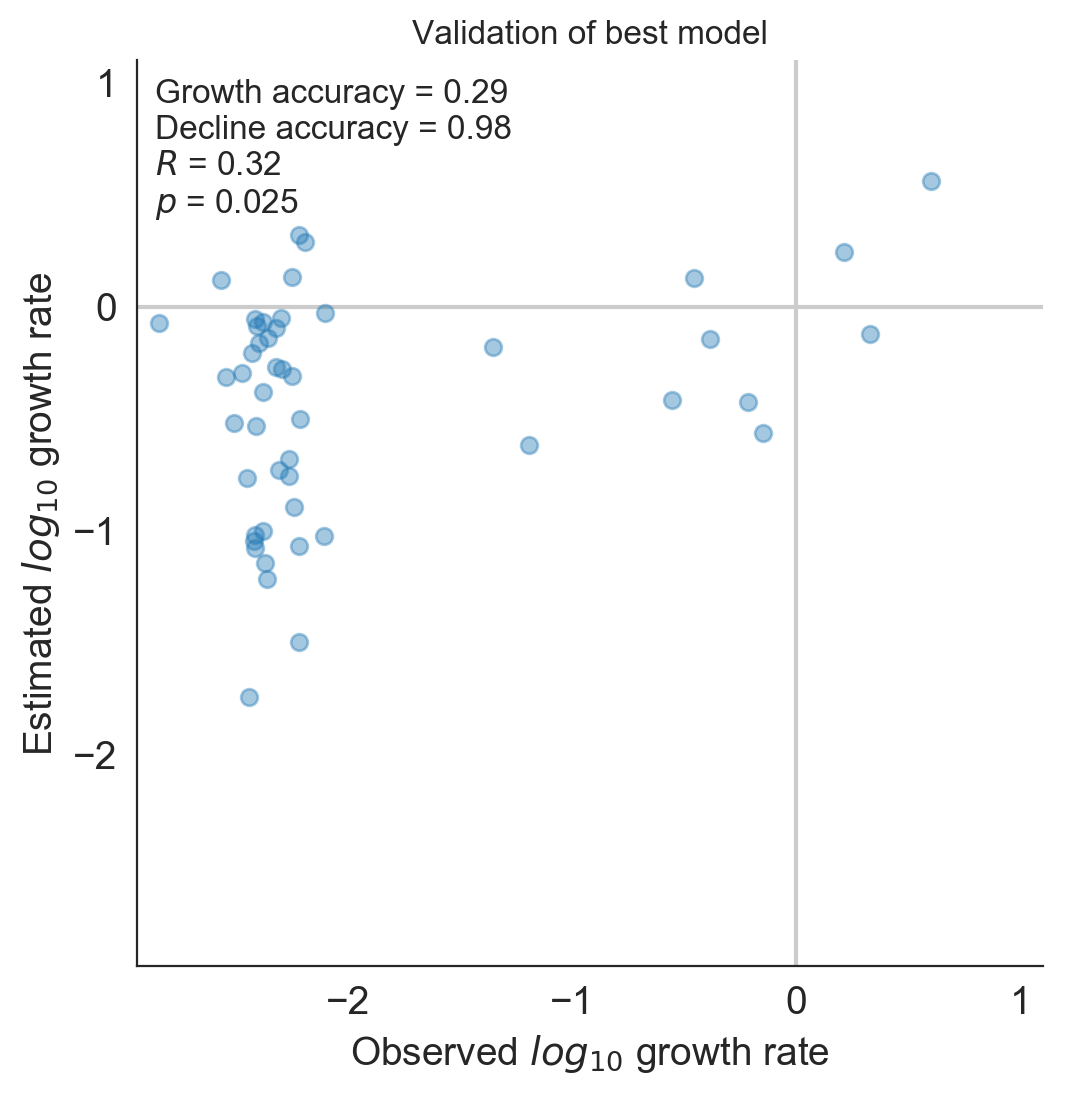

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

ax.axhline(color="#cccccc", zorder=-5)
ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=12,
    horizontalalignment="left",
    verticalalignment="center",
    transform=ax.transAxes
)

ax.set_xlabel("Observed $log_{10}$ growth rate")
ax.set_ylabel("Estimated $log_{10}$ growth rate")
ax.set_title("Validation of best model", fontsize=12)

ticks = np.arange(-6, 4, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(log_lower_limit, log_upper_limit)
ax.set_ylim(log_lower_limit, log_upper_limit)
ax.set_aspect("equal")

#plt.savefig("../manuscript/figures/validation-of-best-model-for-natural-populations.pdf")

## Estimated and observed closest strains per timepoint

Create a figure similar to Figure 2D in Neher et al. 2014 showing the minimum estimated distance to the future and minimum observed distance to the future per timepoint.

In [85]:
sorted_df = full_forecasts.dropna().sort_values(
    ["timepoint"]
).copy()

In [86]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)

In [87]:
best_fitness_rank_by_timepoint_df = sorted_df.sort_values(
    ["timepoint", "fitness"],
    ascending=False
).groupby("timepoint")["timepoint_rank"].first().reset_index()

In [88]:
best_fitness_rank_by_timepoint_df.head()

,timepoint,timepoint_rank
0,2023-10-01,0.170635
1,2024-04-01,0.688889
2,2024-10-01,0.222222
3,2025-04-01,0.306349
4,2025-10-01,0.039683


Text(0,0.5,'Number of timepoints')

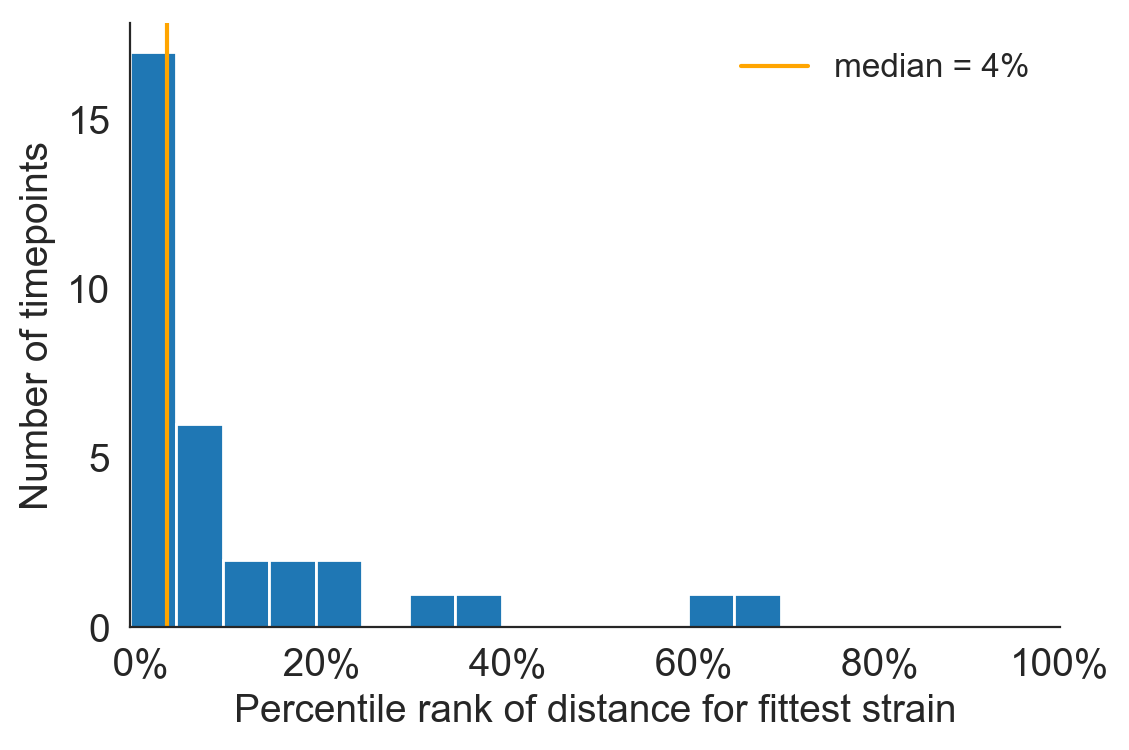

In [89]:
median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xlim(0, 1)

ax.legend(
    frameon=False
)
ax.set_xlabel("Percentile rank of distance for fittest strain")
ax.set_ylabel("Number of timepoints")

## Merge validation figures into subpanels of one figure

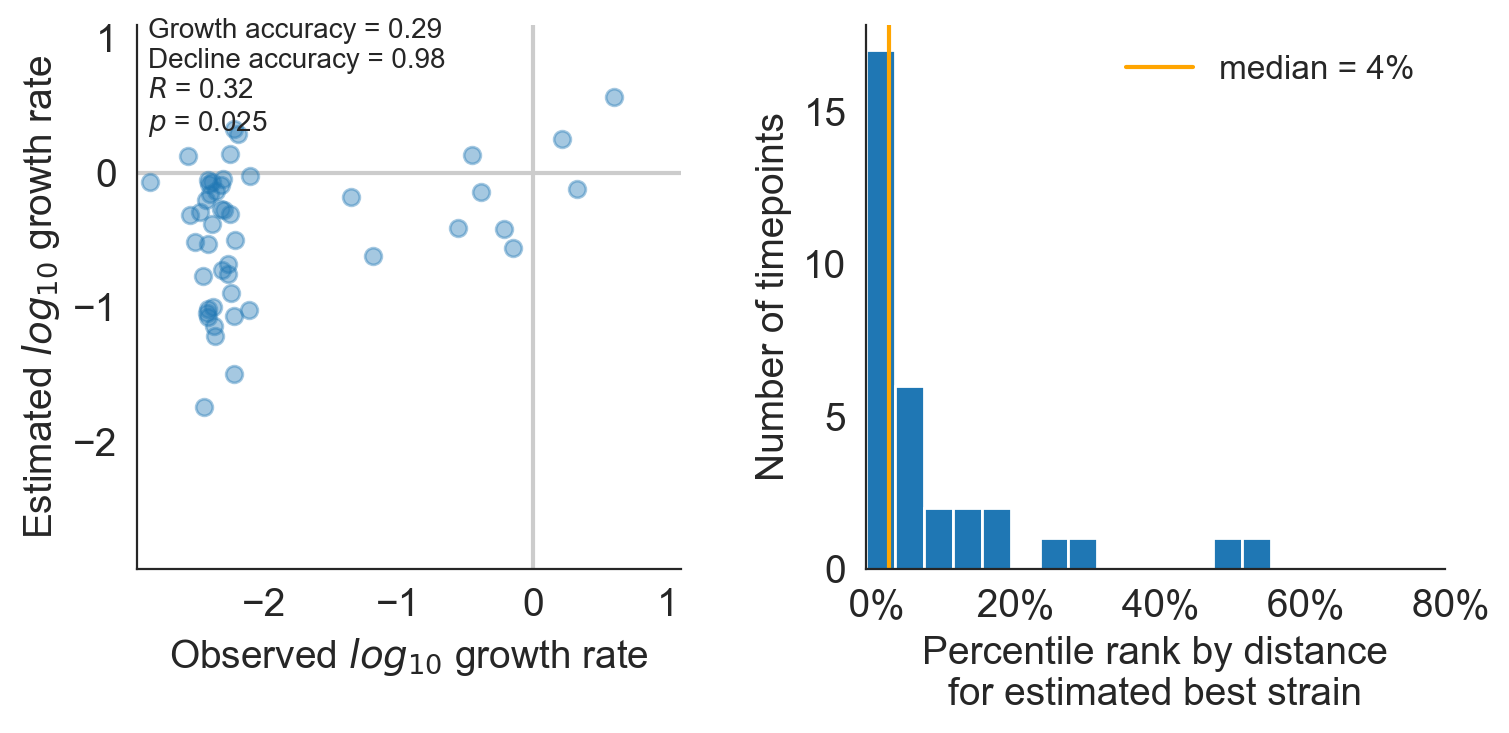

In [92]:
fig = plt.figure(figsize=(8, 4), facecolor='w')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)

#
# Clade growth rate correlations
#

clade_ax = fig.add_subplot(gs[0])
clade_ax.plot(
    large_clades["log_observed_growth_rate"],
    large_clades["log_estimated_growth_rate"],
    "o",
    alpha=0.4
)

clade_ax.axhline(color="#cccccc", zorder=-5)
clade_ax.axvline(color="#cccccc", zorder=-5)

if p < 0.001:
    p_value = "$p$ < 0.001"
else:
    p_value = "$p$ = %.3f" % p

clade_ax.text(
    0.02,
    0.9,
    "Growth accuracy = %.2f\nDecline accuracy = %.2f\n$R$ = %.2f\n%s" % (growth_accuracy, decline_accuracy, r, p_value),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="center",
    transform=clade_ax.transAxes
)

clade_ax.set_xlabel("Observed $log_{10}$ growth rate")
clade_ax.set_ylabel("Estimated $log_{10}$ growth rate")

ticks = np.arange(-6, 4, 1)
clade_ax.set_xticks(ticks)
clade_ax.set_yticks(ticks)

clade_ax.set_xlim(log_lower_limit, log_upper_limit)
clade_ax.set_ylim(log_lower_limit, log_upper_limit)
clade_ax.set_aspect("equal")

#
# Estimated closest strain to the future ranking
#

rank_ax = fig.add_subplot(gs[1])

median_best_rank = best_fitness_rank_by_timepoint_df["timepoint_rank"].median()

rank_ax.hist(best_fitness_rank_by_timepoint_df["timepoint_rank"], bins=np.arange(0, 1.01, 0.05), label=None)
rank_ax.axvline(
    median_best_rank,
    color="orange",
    label="median = %i%%" % round(median_best_rank * 100, 0)
)
rank_ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in [0, 0.2, 0.4, 0.6, 0.8, 1.0]])
rank_ax.set_xlim(0, 1)

rank_ax.legend(
    frameon=False
)
rank_ax.set_xlabel("Percentile rank by distance\nfor estimated best strain")
rank_ax.set_ylabel("Number of timepoints")

gs.tight_layout(fig)

plt.savefig("../manuscript/figures/validation-of-best-model-for-simulated-populations.png")